In [46]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import r2_score,mean_squared_error 

plt.rcParams["figure.figsize"] = (16,9)

In [47]:
df = yf.download('PNC', start='2016-01-01', end='2022-12-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,94.000000,94.260002,92.260002,93.160004,75.467262,3040300
2016-01-05,93.230003,93.730003,92.269997,93.290001,75.572586,1911000
2016-01-06,91.339996,92.750000,91.209999,91.599998,74.203560,2576200
2016-01-07,90.010002,90.849998,88.879997,89.279999,72.324142,2658300
2016-01-08,89.949997,90.389999,87.669998,87.959999,71.254860,2358000


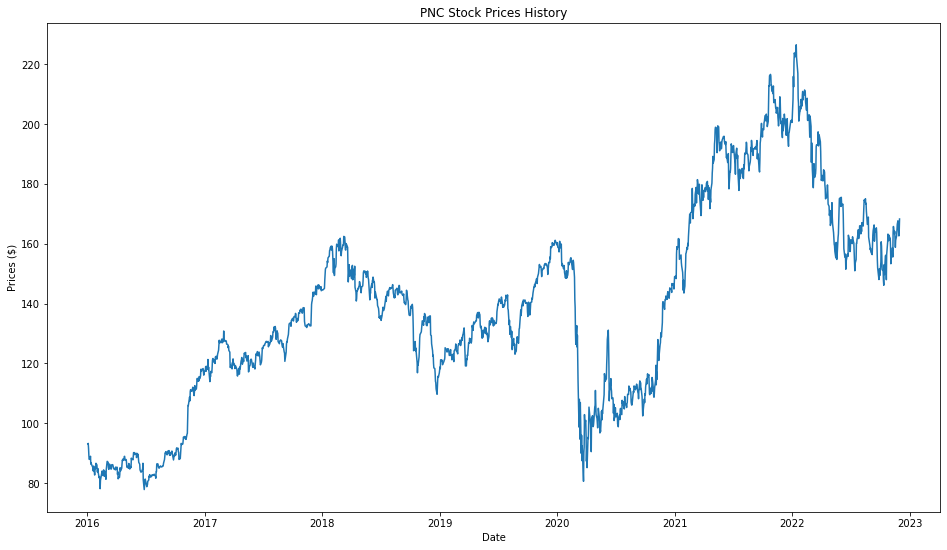

In [48]:
plt.title('PNC Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.show()

**Normalize all data**

In [49]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [50]:

test_data = scaled_data[training_data_len-60: , : ]
X_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [51]:
model = keras.Sequential()
model.add(layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(50, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1333/1333 [==============================] - 89s 63ms/step - loss: 0.0017
Epoch 2/3
1333/1333 [==============================] - 31s 23ms/step - loss: 9.0893e-04
Epoch 3/3
1333/1333 [==============================] - 35s 26ms/step - loss: 5.7819e-04


In [53]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

11/11 [==============================] - 2s 10ms/step


C:\Users\SARAN\AppData\Local\Temp\ipykernel_17532\2150155870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['y_pred'] = y_pred


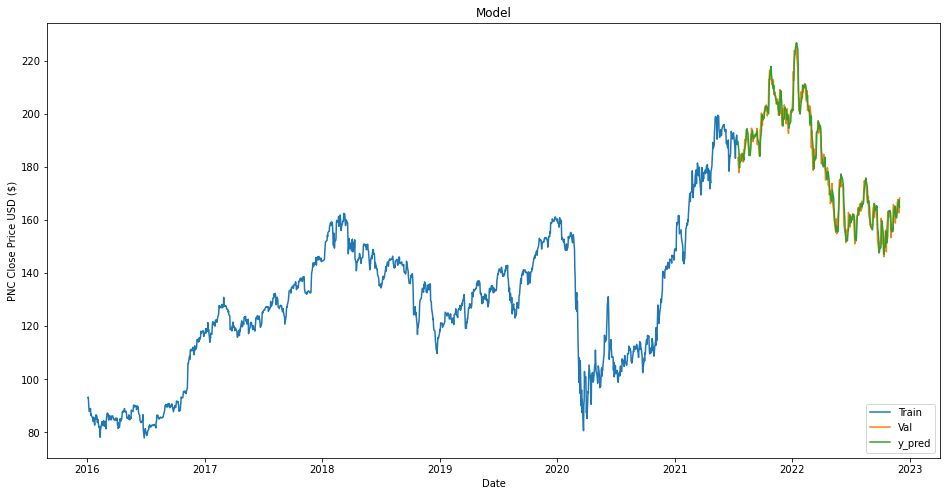

Test MSE : 12.937088853902392
Test R-score:  0.9678443227853814


In [54]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['y_pred'] = y_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('PNC Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'y_pred']])
plt.legend(['Train', 'Val', 'y_pred'], loc='lower right')
plt.show()
mse = mean_squared_error(y_test,y_pred)
r_score = r2_score(y_test,y_pred)
print("Test MSE :",mse)
print("Test R-score: ", r_score)
